## End to End Pipeline 
Predicting Survival on the Titanic

The objective of this notebook is to build a machine learning pipleline to predict the survival on the Titanic. The pipeline should include reading the data, engineering the features, selecting the features and prediting the target. 
As part of the pipleline, open-sources for feature engineering and transformations should be used

In [45]:
#Import minimum packages

import re
import pandas as pd
import numpy as np

#Viz
import matplotlib.pyplot as plt
import seaborn as sns
#Test-train split
from sklearn.model_selection import train_test_split
#Features scaling
from sklearn.preprocessing  import StandardScaler
#Model 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, roc_auc_score 
#To save the model and scaler 
import joblib

In [6]:
#New packages for pipeline

from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import MinMaxScaler, Binarizer
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder
)

from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import preporcessors as pp


### Prepare the data

In [34]:
data = pd.read_csv(r'https://www.openml.org/data/get_csv/16826755/phpMYEkM')

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pclass     1309 non-null   int64 
 1   survived   1309 non-null   int64 
 2   name       1309 non-null   object
 3   sex        1309 non-null   object
 4   age        1309 non-null   object
 5   sibsp      1309 non-null   int64 
 6   parch      1309 non-null   int64 
 7   ticket     1309 non-null   object
 8   fare       1309 non-null   object
 9   cabin      1309 non-null   object
 10  embarked   1309 non-null   object
 11  boat       1309 non-null   object
 12  body       1309 non-null   object
 13  home.dest  1309 non-null   object
dtypes: int64(4), object(10)
memory usage: 143.3+ KB


In [36]:
data.groupby(['name']).nunique().reset_index().sort_values('cabin',ascending=False)

,name,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,"Abbing, Mr. Anthony",1,1,1,1,1,1,1,1,1,1,1,1,1
858,"Newsom, Miss. Helen Monypeny",1,1,1,1,1,1,1,1,1,1,1,1,1
876,"Nysveen, Mr. Johan Hansen",1,1,1,1,1,1,1,1,1,1,1,1,1
875,"Nysten, Miss. Anna Sofia",1,1,1,1,1,1,1,1,1,1,1,1,1
874,"Nye, Mrs. (Elizabeth Ramell)",1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,"Gibson, Miss. Dorothy Winifred",1,1,1,1,1,1,1,1,1,1,1,1,1
433,"Gheorgheff, Mr. Stanio",1,1,1,1,1,1,1,1,1,1,1,1,1
432,"Geiger, Miss. Amalie",1,1,1,1,1,1,1,1,1,1,1,1,1
431,"Gee, Mr. Arthur H",1,1,1,1,1,1,1,1,1,1,1,1,1


In [22]:
data.describe()


,pclass,survived,sibsp,parch
count,1309.000000,1309.000000,1309.000000,1309.000000
mean,2.294882,0.381971,0.498854,0.385027
std,0.837836,0.486055,1.041658,0.865560
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000,0.000000
75%,3.000000,1.000000,1.000000,0.000000
max,3.000000,1.000000,8.000000,9.000000


In [38]:
(data.cabin=='?').mean()

0.774637127578304

### Feature Cleansing 

In [68]:
#Replace ? with nam
data = data.replace('?',np.nan)
#Split cabin and get the first one only
data.cabin = data.cabin.apply(lambda x: str(x).split()[0] if str(x).split()[0] else x)

In [40]:
#Extract the title

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

<AxesSubplot:xlabel='title', ylabel='count'>

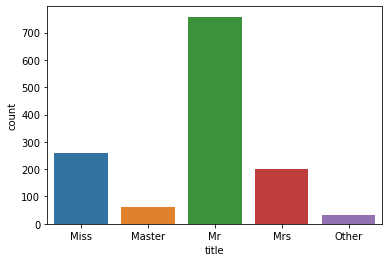

In [46]:
sns.countplot( x=data['title'])

In [47]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [48]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


# Begin Assignment

### Configuration

In [57]:
# list of variables to be used in the pipeline's transformers

NUMERICAL_VARIABLES = [var for var in data.columns if data[var].dtype=='float']
CATEGORICAL_VARIABLES = [var for var in data.columns if data[var].dtype=='O' and var != 'cabin']
CABIN = ['cabin']

## Train Test Split

In [75]:
x_train, x_test, y_train, y_test = train_test_split(data.drop('survived',axis=1),data.survived,test_size=.2,random_state=0)

In [76]:
x_train.shape, x_test.shape

((1047, 9), (262, 9))

In [78]:
data['cabin'].apply(lambda x: x[0])

0       B
1       C
2       C
3       C
4       C
       ..
1304    n
1305    n
1306    n
1307    n
1308    n
Name: cabin, Length: 1309, dtype: object